# Image Classification 

- **Goal:** Classify fashion images (shirts, shoes, bags etc) using CNN and transfer learning

- **Dataset:** Fashion-MNIST

- **Techs:** 
1. Data loading and augmention 
2. CNN model building
3. Trasnfer learning with ResNet18
4. Training, vaidation, and error analysis
5. Streamlit Deployment

In [9]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time

## Set Device

In [2]:
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


## Set Hyperparameters

In [3]:
BATCH_SIZE = 64
EPOCHS = 10
LR = 0.001
IMG_SIZE = 64  # resize to match transfer learning model input

## Data Augmentation

In [4]:
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## Download and Load Dataset

In [5]:
# 5. Load FashionMNIST dataset
train_data = datasets.FashionMNIST(root="./data", train=True, transform=transform_train, download=True)
test_data = datasets.FashionMNIST(root="./data", train=False, transform=transform_test, download=True)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 26.4M/26.4M [00:09<00:00, 2.85MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 265kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.79MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 25.0MB/s]


In [6]:
# Class labels
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## Visualize Images

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

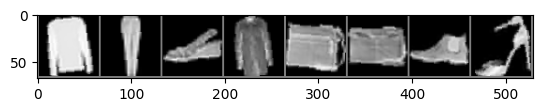

Pullover     Trouser      Sandal       Shirt        Bag          Bag          Ankle boot   Sandal      


In [10]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]))
print(' '.join(f'{classes[labels[j]]:12s}' for j in range(8)))

## Define CNN Model (Transfer Learning - ResNet18)

In [11]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(classes))  # replace final layer
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/javhaa/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:07<00:00, 6.41MB/s]


## Define Optimzer and Loss

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

## Train a Model

In [13]:
train_losses, test_losses, accuracies = [], [], []

for epoch in range(EPOCHS):
    start = time.time()
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images.repeat(1, 3, 1, 1))  # replicate grayscale to RGB
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images.repeat(1, 3, 1, 1))
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    test_losses.append(val_loss / len(test_loader))
    accuracies.append(acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {train_losses[-1]:.4f} | "
          f"Val Loss: {test_losses[-1]:.4f} | Accuracy: {acc:.2f}% | "
          f"Time: {time.time()-start:.1f}s")

print("Training complete.")

Epoch [1/10] | Train Loss: 0.3807 | Val Loss: 0.2925 | Accuracy: 89.27% | Time: 131.8s
Epoch [2/10] | Train Loss: 0.2669 | Val Loss: 0.2996 | Accuracy: 89.19% | Time: 119.5s
Epoch [3/10] | Train Loss: 0.2369 | Val Loss: 0.2362 | Accuracy: 91.34% | Time: 112.5s
Epoch [4/10] | Train Loss: 0.2179 | Val Loss: 0.2147 | Accuracy: 92.15% | Time: 114.6s
Epoch [5/10] | Train Loss: 0.1981 | Val Loss: 0.2094 | Accuracy: 92.38% | Time: 111.4s
Epoch [6/10] | Train Loss: 0.1846 | Val Loss: 0.2255 | Accuracy: 91.96% | Time: 108.2s
Epoch [7/10] | Train Loss: 0.1871 | Val Loss: 0.2048 | Accuracy: 92.95% | Time: 107.9s
Epoch [8/10] | Train Loss: 0.1609 | Val Loss: 0.1869 | Accuracy: 93.27% | Time: 131.9s
Epoch [9/10] | Train Loss: 0.1526 | Val Loss: 0.1954 | Accuracy: 93.47% | Time: 120.7s
Epoch [10/10] | Train Loss: 0.1449 | Val Loss: 0.1959 | Accuracy: 93.22% | Time: 136.5s
Training complete.


## Plot Learning Curves

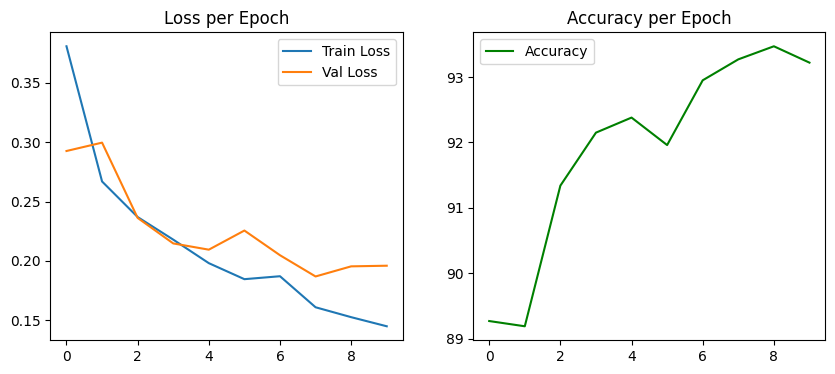

In [14]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Val Loss')
plt.legend(); plt.title("Loss per Epoch")

plt.subplot(1,2,2)
plt.plot(accuracies, label='Accuracy', color='green')
plt.legend(); plt.title("Accuracy per Epoch")
plt.show()

## Error Analysis

In [15]:
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images.repeat(1, 3, 1, 1))
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=classes))


              precision    recall  f1-score   support

 T-shirt/top       0.83      0.94      0.88      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.94      0.85      0.90      1000
       Dress       0.95      0.93      0.94      1000
        Coat       0.85      0.95      0.90      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.85      0.74      0.79      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



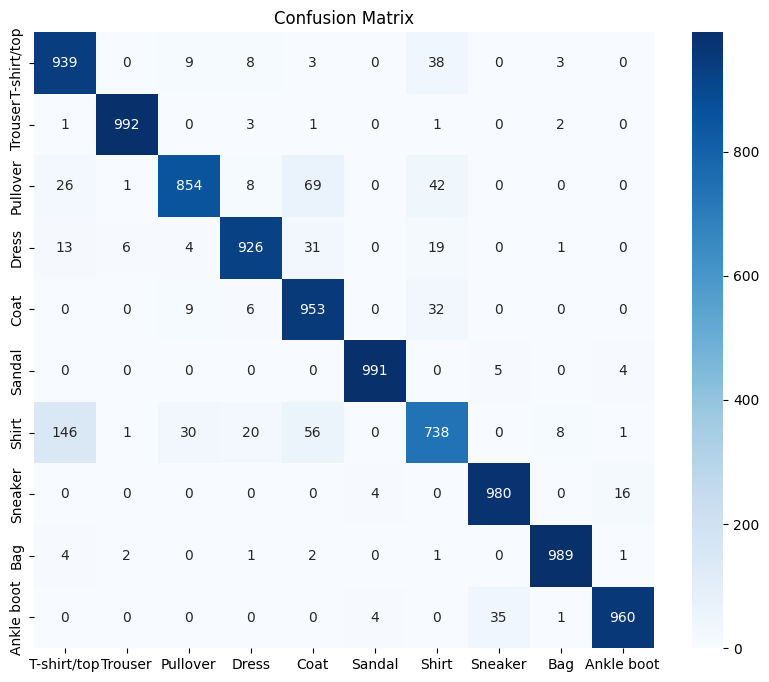

In [16]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.show()

## Save Model

In [17]:
torch.save(model.state_dict(), "fashion_cnn_resnet18.pth")
print("Model saved.")

Model saved.
